✅ Random Forest Accuracy: 0.5882352941176471
✅ Random Forest F1 Score: 0.5329923273657289
✅ Logistic Regression Accuracy: 0.6470588235294118
✅ Logistic Regression F1 Score: 0.6274509803921569

🔁 Overlapping Top Genes in Both Models:


<Figure size 1400x1000 with 0 Axes>

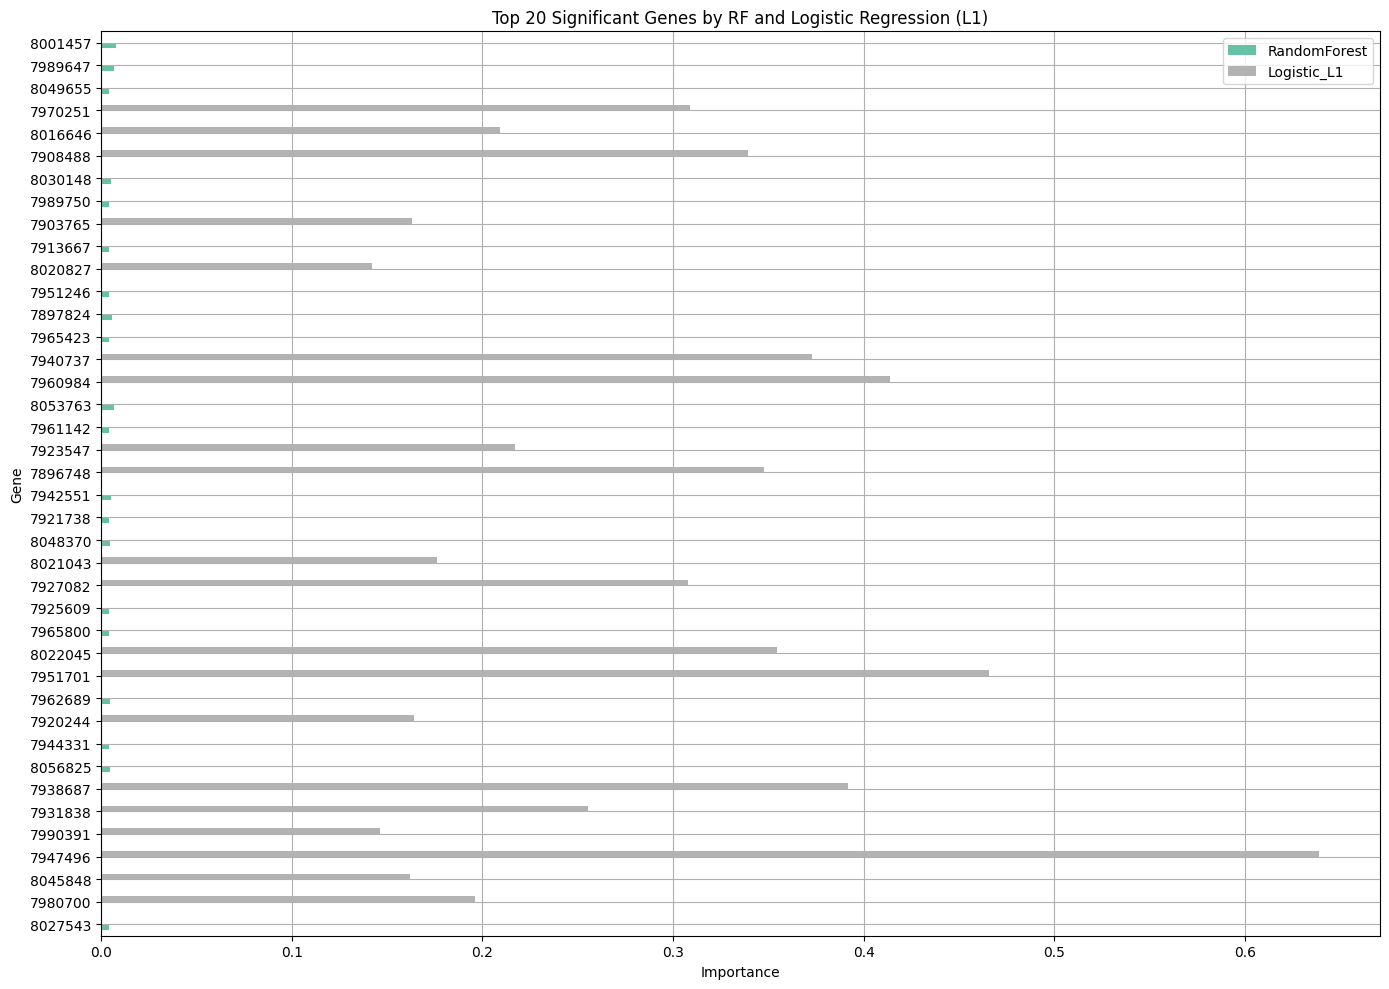

In [42]:
# 📌 STEP 1: Install dependencies
# !pip install openpyxl scikit-learn matplotlib seaborn pandas

# 📌 STEP 2: Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# 📌 STEP 3: Load dataset
df = pd.read_excel('/content/GSE66676_dataset.xlsx')

# 📌 STEP 4: Clean and prepare data
target_col = "Status"
non_feature_cols = ['Sample', 'Sample_title', 'Status', 'Sample_characteristics_ch1']
df = df.dropna(axis=1, how='any')
X = df.drop(columns=[col for col in non_feature_cols if col in df.columns], errors='ignore')
X = X.select_dtypes(include=[np.number])
X.columns = X.columns.astype(str)

# Labels
y = df[target_col]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 📌 STEP 5: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

# 📌 STEP 6: Random Forest Model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds, average='weighted')
rf_importance = pd.Series(rf.feature_importances_, index=X.columns)
top20_rf = rf_importance.sort_values(ascending=False).head(20)

# 📌 STEP 7: Logistic Regression (L1)
logreg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_preds)
logreg_f1 = f1_score(y_test, logreg_preds, average='weighted')
logreg_importance = pd.Series(np.abs(logreg.coef_).mean(axis=0), index=X.columns)
top20_lr = logreg_importance.sort_values(ascending=False).head(20)

# 📌 STEP 8: Display scores
print("✅ Random Forest Accuracy:", rf_accuracy)
print("✅ Random Forest F1 Score:", rf_f1)
print("✅ Logistic Regression Accuracy:", logreg_accuracy)
print("✅ Logistic Regression F1 Score:", logreg_f1)

# 📌 STEP 9: Common genes
overlap = set(top20_rf.index) & set(top20_lr.index)
print("\n🔁 Overlapping Top Genes in Both Models:")
for gene in overlap:
    print(gene)

# 📌 STEP 10: Combine and plot
importance_df = pd.DataFrame({
    'Gene': list(set(top20_rf.index).union(top20_lr.index))
})
importance_df['RandomForest'] = importance_df['Gene'].map(top20_rf)
importance_df['Logistic_L1'] = importance_df['Gene'].map(top20_lr)
importance_df = importance_df.fillna(0).set_index('Gene')

# 📌 Plot
plt.figure(figsize=(14, 10))
importance_df.plot(kind='barh', figsize=(14, 10), colormap='Set2')
plt.title("Top 20 Significant Genes by RF and Logistic Regression (L1)")
plt.xlabel("Importance")
plt.tight_layout()
plt.grid(True)
plt.show()


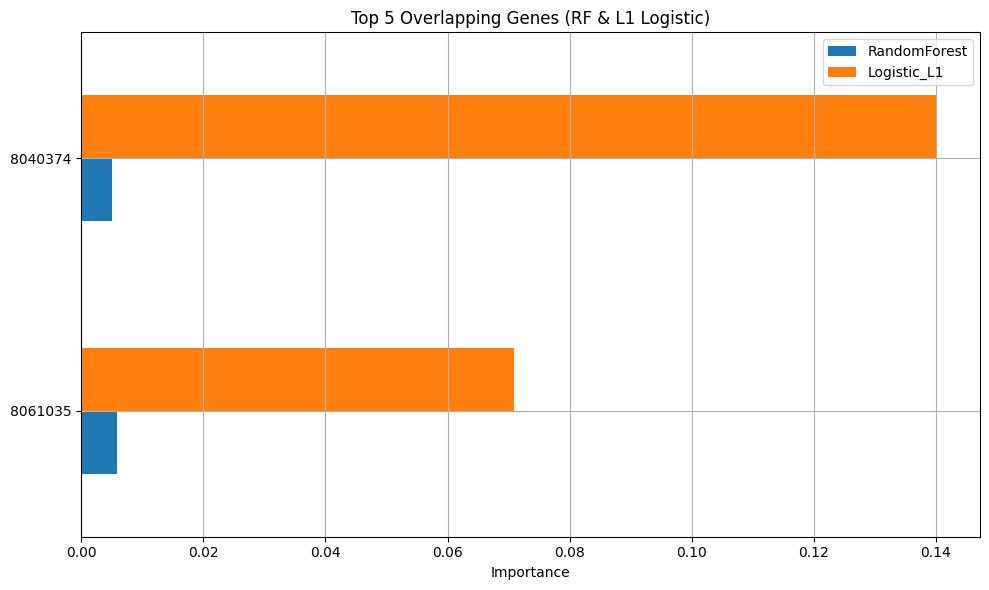

✅ Random Forest Accuracy: 0.47619047619047616
✅ Random Forest F1 Score: 0.43901196842373313
✅ Logistic Regression Accuracy: 0.5238095238095238
✅ Logistic Regression F1 Score: 0.48374905517762656
🔁 Top 5 Common Genes: ['8061035', '8040374']


In [44]:
# 📌 STEP 1: Install dependencies
# !pip install openpyxl scikit-learn matplotlib pandas seaborn

# 📌 STEP 2: Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# 📌 STEP 3: Load data
df = pd.read_excel("/content/GSE66676_dataset.xlsx")
df = df.dropna(axis=1, how='any')  # drop columns with NaNs

# 📌 STEP 4: Prepare features
y = df["Status"]
X = df.drop(columns=["Sample", "Sample_title", "Status", "Sample_characteristics_ch1"], errors="ignore")
X = X.select_dtypes(include=[np.number])
X.columns = X.columns.astype(str)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 📌 STEP 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# 📌 STEP 6: Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_importance = pd.Series(rf.feature_importances_, index=X.columns)
top_rf = rf_importance.sort_values(ascending=False).head(50)

# 📌 STEP 7: Logistic Regression with L1 (Multiclass-safe)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, _, _ = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

logreg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Take mean absolute coef across classes (multiclass-safe)
avg_coefs = np.mean(np.abs(logreg.coef_), axis=0)
coef = pd.Series(avg_coefs, index=X.columns)
top_logreg = coef.sort_values(ascending=False).head(50)

# 📌 STEP 8: Overlap
common_genes = list(set(top_rf.index) & set(top_logreg.index))
common_top = common_genes[:5]  # take top 5 overlapping genes

# 📌 STEP 9: Plot
plot_df = pd.DataFrame({
    "RandomForest": rf_importance[common_top],
    "Logistic_L1": coef[common_top]
})

plot_df.plot(kind="barh", figsize=(10, 6), title="Top 5 Overlapping Genes (RF & L1 Logistic)")
plt.xlabel("Importance")
plt.tight_layout()
plt.grid(True)
plt.show()

# 📌 STEP 10: Evaluation
rf_preds = rf.predict(X_test)
log_preds = logreg.predict(X_test_scaled)

print("✅ Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("✅ Random Forest F1 Score:", f1_score(y_test, rf_preds, average='weighted'))
print("✅ Logistic Regression Accuracy:", accuracy_score(y_test, log_preds))
print("✅ Logistic Regression F1 Score:", f1_score(y_test, log_preds, average='weighted'))
print("🔁 Top 5 Common Genes:", common_top)
